In [27]:
#Here we will find a conventional treatment plan for real patient to make sure it makes sense
#Also, will check and incorporate smoothing

In [2]:
import numpy as np
import scipy.optimize
import pandas as pd
import operator
import scipy.io
import scipy
import scipy.sparse
import time
import sys
import os

/home/rilevin/miniconda3/envs/mmort/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [3]:
# np.show_config()

In [4]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'mmort')))
from optimization_tools import *
from experiments import *

In [5]:
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'ProstateExample_BODY_not_reduced_with_OAR_constraints.mat'))
data = scipy.io.loadmat(data_path)
Alpha = np.array([0.35, 0.35])
Beta = np.array([0.175, 0.175])
Gamma = np.array([np.array([0.35, 0.35]),
                  np.array([0.35, 0.35]),
                  np.array([0.35, 0.35]),
                  np.array([0.35, 0.35]),
                  np.array([0.35, 0.35])               
                 ])
Delta = np.array([np.array([0.07, 0.07]),
                  np.array([0.07, 0.07]),
                  np.array([0.175, 0.175]),
                  np.array([0.175, 0.175]),
                  np.array([0.175, 0.175])                
                 ])
modality_names = np.array(['Aphoton', 'Aproton'])

In [6]:
data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar  1 01:37:10 2020',
 '__version__': '1.0',
 '__globals__': [],
 'Aproton': <32061x16358 sparse matrix of type '<class 'numpy.float64'>'
 	with 16735951 stored elements in Compressed Sparse Column format>,
 'Organ': array([[array(['Target'], dtype='<U6'), array(['Rectum'], dtype='<U6'),
         array(['Bladder'], dtype='<U7'), array(['R Femur'], dtype='<U7'),
         array(['L Femur'], dtype='<U7'), array(['BODY'], dtype='<U4')]],
       dtype=object),
 'beamlet_pos': array([[-70.,  15.],
        [-70.,  20.],
        [-70.,  25.],
        ...,
        [ 50.,  20.],
        [ 50.,  25.],
        [ 50.,  30.]]),
 'maxAreducedphoton': <30207x2289 sparse matrix of type '<class 'numpy.float64'>'
 	with 16478507 stored elements in Compressed Sparse Column format>,
 'num_beamlets': array([[480, 405, 497, 493, 414]], dtype=uint16),
 'num_voxels': array([[ 6782,  1773, 11595,  5958,  5952,     1]]),
 'maxAreducedproton':

In [7]:
#redo this one
def objective_N(N,  Alpha = Alpha, Beta = Beta, Gamma = Gamma, Delta = Delta, data = data, modality_names = modality_names):
    T_list, T, H, alpha, gamma, B, D, C = construct_auto_param_solver_input(N, Alpha, Beta, Gamma, Delta, data, modality_names)
    num_tumor_voxels = np.squeeze(data['num_voxels'])[0]
    #Assuming N>0, and two-modality case
    Rx = 80
    LHS1 = T_list[0]
    LHS2 = T_list[1]
    RHS1 = np.array([Rx/(np.sum(N))]*LHS1.shape[0])
    RHS2 = np.array([Rx/(np.sum(N))]*LHS2.shape[0])

    print('I am HERE')
    u1_guess = scipy.optimize.lsq_linear(LHS1, RHS1, bounds = (0, np.inf), tol=1e-4, lsmr_tol=1e-2, max_iter=30, verbose=1).x#nnls_predotted(LHS1.T.dot(LHS1).toarray(), LHS1.T.dot(RHS1), tol = 1e-4)
    u2_guess = scipy.optimize.lsq_linear(LHS2, RHS2, bounds = (0, np.inf), tol=1e-4, lsmr_tol=1e-2, max_iter=30, verbose=1).x#nnls_predotted(LHS2.T.dot(LHS2).toarray(), LHS2.T.dot(RHS2), tol = 1e-4)
    
    
    u_init11 = np.concatenate([u1_guess, u2_guess])
#     u_init11 = 10*np.ones(2289+16358)
    print("GOT HERE!")
    u, eta_0, eta, auto_param_obj_history, auto_param_relaxed_obj_history = solver_auto_param(u_init11, T, H, alpha, gamma, B, D, C, eta_step = 0.1, ftol = 1e-3, max_iter = 300, verbose = 1)
    
    return obj_u_opt_N_opt(u, T, alpha, B, N, num_tumor_voxels, Td = 10)

def informative_objective_N(N,  Alpha = Alpha, Beta = Beta, Gamma = Gamma, Delta = Delta, data = data, modality_names = modality_names):
    T_list, T, H, alpha, gamma, B, D, C = construct_auto_param_solver_input(N, Alpha, Beta, Gamma, Delta, data, modality_names)
    num_tumor_voxels = np.squeeze(data['num_voxels'])[0]
    #Assuming N>0, and two-modality case
    Rx = 80
    LHS1 = T_list[0]
    LHS2 = T_list[1]
    RHS1 = np.array([Rx/(np.sum(N))]*LHS1.shape[0])
    RHS2 = np.array([Rx/(np.sum(N))]*LHS2.shape[0])

#     u1_guess = scipy.optimize.lsq_linear(LHS1, RHS1, bounds = (0, np.inf), tol=1e-3, lsmr_tol=1e-1, max_iter=30, verbose=1).x#nnls_predotted(LHS1.T.dot(LHS1).toarray(), LHS1.T.dot(RHS1), tol = 1e-4)
#     u2_guess = scipy.optimize.lsq_linear(LHS2, RHS2, bounds = (0, np.inf), tol=1e-3, lsmr_tol=1e-1, max_iter=30, verbose=1).x#nnls_predotted(LHS2.T.dot(LHS2).toarray(), LHS2.T.dot(RHS2), tol = 1e-4)
    
#     u_init11 = np.concatenate([u1_guess, u2_guess])
#     u_init11 = 10*np.ones(2289+16358)
    u, eta_0, eta, auto_param_obj_history, auto_param_relaxed_obj_history = solver_auto_param(u_init11, T, H, alpha, gamma, B, D, C, eta_step = 0.5, ftol = 1e-3, max_iter = 300, verbose = 1)
    
    return u, eta_0, eta, auto_param_obj_history, auto_param_relaxed_obj_history, obj_u_opt_N_opt(u, T, alpha, B, N, num_tumor_voxels, Td = 10)



def optimize_N(N_init, N_SUM_MAX = 45, max_iter = 6):
    """Value function of N optimization as per Algorithm 1 of the paper.
    Uses trust-region-constrained from scipy

    Parameters
    ----------
    N_init : np.array of shape (M,), where M is the number of modalities
        Initial array of fractions
    N_SUM_MAX : float
        Max treatment course length, the bound on the sum of N
    max_iter : int
        Max number of iterations

    Returns
    -------
    x : np.array of shape (M,)
        Optimal fractionation schedule N
    res : OptimizationResult from scipy
        Metadata of the algorithm
    Nk_hist : list
        Iterates N history 
    """
    Nk_hist = []
    def callback(xk, OptRes):
        Nk_hist.append(xk)
        return 0

    bounds =  scipy.optimize.Bounds([1, 1], [np.inf, np.inf]) #or 0,0
    linear_constraint = scipy.optimize.LinearConstraint(np.array([1,1]), -np.inf, N_SUM_MAX)
   
    x0 = np.array(N_init)
    res = scipy.optimize.minimize(objective_N, x0, method='trust-constr',  jac="2-point", hess=BFGS(), 
                         constraints=[linear_constraint], options={'verbose': 4, 'maxiter': max_iter}, bounds=bounds, 
                         callback = callback)
    x = res.x
    print('NEW N rounded:', np.rint(x), 'EXACT new N:', x)
    return x, res, obj_Nk_hist, Nk_hist


In [ ]:
import scipy.sparse
def construct_beam_smoothing_matrix(beam, k, eps = 5, mode = 'relative_avg'):
    """Compute a smoothing matrix. (Linear constraint: abs diff between neighbors <= k)
    
    Parameters
    ----------
    beam : np.array of shape (num_beamlets,None)
        beamlet positions, usually in 2D or 3D
    k : float
        |a-b| <= k, bound on the difference between neighbors
    eps : float
        radius in which to look for neighbors
        
    Returns
    -------
    L_lhs : sparse matrix 
        Lhs of the smoothing constraint
    L_rhs : np.array
        Rhs of the smoothing constraint
        
    Notes
    -----
    Could replace this with abs of the second derivate
    Abs relative difference is not great for there are some zero beamlets
    Abs relative difference being not greater than k*mean ruins the sparsity
    Probably, heuristically choosing k is the best approach
    Should also align with physics well
    """
    print(beam.shape)
    tol = eps*0.01 #tolerance for inexact coordinates
    distances = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(beam))
    #Find which points are neighbors, points are not neignbors for themselves:
    #Left_beamlets are the first points in every pair of neighbors
    #Right_beamlets are the second points in every pair of neighbors
    Left_beamlets, Right_beamlets = np.where((distances>tol) & (distances<eps+tol))
    #Initialize num_neighbors*num_beamlets constraint matrix with zeros
    L_lhs = []#np.zeros(Left_beamlets.shape[0], beam.shape[0]) #a-b from |a-b|
    for constr_ind in range(len(Left_beamlets)):
        i = Left_beamlets[constr_ind]
        j = Right_beamlets[constr_ind]
        #|a-b|<=k is equiv to a-b <= k and b-a <= k
        constraint_ij = np.zeros(beam.shape[0]) #u_i - u_j <=k
        if mode == 'absolute':
            constraint_ij[i] = 1
            constraint_ij[j] = -1
        if mode == 'relative_avg':
            constraint_ij[i] = 1-k
            constraint_ij[j] = -1-k
        if mode == 'relative':
            constraint_ij[i] = 1-k
            constraint_ij[j] = -1
        L_lhs.append(constraint_ij)
        constraint_ji = np.zeros(beam.shape[0]) #u_j - u_i <=k
        if mode == 'absolute':
            constraint_ji[i] = -1
            constraint_ji[j] = 1
        if mode == 'relative_avg':
            constraint_ji[i] = -1-k/2
            constraint_ji[j] = 1-k/2
        if mode == 'relative':
            constraint_ji[i] = -1-k
            constraint_ji[j] = 1
        L_lhs.append(constraint_ji)
    L_lhs = scipy.sparse.csr_matrix(L_lhs)
    if mode == 'absolute':
        L_rhs = np.ones(L_lhs.shape[0])*k
    else: #same for both relative and relative_avg
        L_rhs =  np.zeros(L_lhs.shape[0])
#     plt.plot(L_rhs)
    print(L_lhs.shape)
    return L_lhs, L_rhs

def construct_smoothing_matrix(beams, k, eps = 5, mode = 'relative_avg'):
    """Compute a smoothing matrix. (Linear constraint: abs diff between neighbors <= k)
    
    Parameters
    ----------
    beams : list of np.arrays of shape (num_beamlets[i],None) for i-th beam
        beams with beamlet positions, usually in 2D or 3D
    k : float
        |a-b| <= k, bound on the difference between neighbors
    eps : float
        radius in which to look for neighbors
        
    Returns
    -------
    L_lhs : sparse block diag matrix 
        Lhs of the smoothing constraint
    L_rhs : np.array
        Rhs of the smoothing constraint
    """
    Lhs_array = [construct_beam_smoothing_matrix(beam, k, eps = eps, mode = mode)[0] for beam in beams]
    L_lhs = scipy.sparse.block_diag(Lhs_array, format='csr')
    if mode == 'absolute':
        L_rhs = np.ones(L_lhs.shape[0])*k
    else: #same for both relative and relative_avg
        L_rhs =  np.zeros(L_lhs.shape[0])
    return L_lhs, L_rhs

In [16]:
data['beamlet_pos'].shape

(2289, 2)

In [18]:
# def construct_beam_smoothing_matrix(beam, k, eps = 5, mode = 'relative_avg'):
"""Compute a smoothing matrix. (Linear constraint: abs diff between neighbors <= k)

Parameters
----------
beam : np.array of shape (num_beamlets,None)
    beamlet positions, usually in 2D or 3D
k : float
    |a-b| <= k, bound on the difference between neighbors
eps : float
    radius in which to look for neighbors

Returns
-------
L_lhs : sparse matrix 
    Lhs of the smoothing constraint
L_rhs : np.array
    Rhs of the smoothing constraint

Notes
-----
Could replace this with abs of the second derivate
Abs relative difference is not great for there are some zero beamlets
Abs relative difference being not greater than k*mean ruins the sparsity
Probably, heuristically choosing k is the best approach
Should also align with physics well
"""
eps = 5
beam = data['beamlet_pos'][beamlet_indices[0]]
print(beam.shape)
tol = eps*0.01 #tolerance for inexact coordinates
distances = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(beam))
#Find which points are neighbors, points are not neignbors for themselves:
#Left_beamlets are the first points in every pair of neighbors
#Right_beamlets are the second points in every pair of neighbors
Left_beamlets, Right_beamlets = np.where((distances>tol) & (distances<eps+tol))

(480, 2)


In [25]:
Left_beamlets

array([  0,   0,   1, ..., 478, 479, 479])

In [23]:
data['beamlet_pos']

array([[-70.,  15.],
       [-70.,  20.],
       [-70.,  25.],
       ...,
       [ 50.,  20.],
       [ 50.,  25.],
       [ 50.,  30.]])

In [22]:
np.where((distances>tol) & (distances<eps+tol))

(array([  0,   0,   1, ..., 478, 479, 479]),
 array([  1,   6,   0, ..., 479, 472, 478]))

In [ ]:
sections = np.array([np.sum(num_beamlets[:i]) for i in range(1,len(num_beamlets))])
beams = np.split(beamlet_pos, sections)

In [10]:
data['Aphoton'].shape

(32061, 2289)

In [11]:
beamlet_indices = np.split(np.arange(data['Aphoton'].shape[1]), np.cumsum(np.squeeze(data['num_beamlets'])))[:-1]

In [14]:
len(beamlet_indices)

5

In [8]:
%%time
T_list, T, H, alpha, gamma, B, D, C = construct_auto_param_solver_input(np.array([43,1]), Alpha, Beta, Gamma, Delta, data, modality_names)
# u_init = 10*np.ones(2289+16358)

getting through 11912 matrices
CPU times: user 8min 14s, sys: 4.62 s, total: 8min 19s
Wall time: 7min 47s


In [9]:
#     T_list, T, H, alpha, gamma, B, D, C = construct_auto_param_solver_input(N, Alpha, Beta, Gamma, Delta, data, modality_names)
#     num_tumor_voxels = np.squeeze(data['num_voxels'])[0]
#Assuming N>0, and two-modality case
N = np.array([43, 1])
Rx = 80
LHS1 = T_list[0]
LHS2 = T_list[1]
RHS1 = np.array([Rx/np.sum(N)]*LHS1.shape[0])
RHS2 = np.array([Rx/np.sum(N)]*LHS2.shape[0])

print('I am HERE')
u1_guess = scipy.optimize.lsq_linear(LHS1, RHS1, bounds = (0, np.inf), tol=1e-3, lsmr_tol=1e-2, max_iter=30, verbose=1).x#nnls_predotted(LHS1.T.dot(LHS1).toarray(), LHS1.T.dot(RHS1), tol = 1e-4)
u2_guess = scipy.optimize.lsq_linear(LHS2, RHS2, bounds = (0, np.inf), tol=1e-3, lsmr_tol=1e-2, max_iter=30, verbose=1).x#nnls_predotted(LHS2.T.dot(LHS2).toarray(), LHS2.T.dot(RHS2), tol = 1e-4)


I am HERE
The maximum number of iterations is exceeded.
Number of iterations 30, initial cost 4.7695e-01, final cost 1.2601e-01, first-order optimality 6.71e-03.
The first-order optimality measure is less than `tol`.
Number of iterations 7, initial cost 1.1198e+00, final cost 7.1103e-01, first-order optimality 8.94e-04.


In [10]:
u_init11 = np.concatenate([u1_guess, u2_guess])
#u_init11 = np.concatenate([u_conv, np.zeros(u2_guess.shape[0])]) 

In [11]:
%%time
u_mult, eta_0, eta, auto_param_obj_history, auto_param_relaxed_obj_history = solver_auto_param(u_init11, T, H, alpha, gamma, B, D, C, eta_step = 0.5, ftol = 1e-3, max_iter = 300, verbose = 1)

wi update took: 2.6454100608825684
      fun: 606787.7311731409
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 17.02150013,  37.1797136 ,   8.21520511, ..., -28.19204891,
       -27.90639026, -27.21470953])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 55
      nit: 50
   status: 1
  success: False
        x: array([ 0.09632545,  0.09506023,  0.0975268 , ..., 27.26241401,
       26.04770458, 24.51357882])
u update took: 4.334158182144165
    iter = 1, stopping criterium:3651262.2935849815, OBJ -287999.8162277846
    This iteration took: 7.515751123428345
wi update took: 1.6740472316741943
      fun: 320849.2470056062
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([15.46511619, 23.15658503, 12.97087377, ..., 41.96006985,
       42.2148211 , 41.70387457])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 53
      nit: 50
   status: 1
  success: False
        x: array([ 0.098351

    iter = 14, stopping criterium:0.173103064864494, OBJ -17432350.73889105
    This iteration took: 7.564610719680786
wi update took: 1.3878536224365234
      fun: 21880044.341974523
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([347.9015844 , 284.01312772, 246.87453483, ..., 124.12980727,
       121.5326546 , 116.796376  ])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 60
      nit: 58
   status: 1
  success: False
        x: array([ 0.        ,  0.        ,  0.        , ..., 27.00594306,
       25.75555608, 24.18169228])
u update took: 4.318852186203003
    iter = 15, stopping criterium:0.17065499274904256, OBJ -20357648.2224251
    This iteration took: 6.233615875244141
wi update took: 1.4264194965362549
      fun: 25909657.661304187
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([241.03186097, 185.62703502, 157.67207181, ..., 260.20239526,
       255.69712983, 246.65257753])
  message: b'ST

wi update took: 1.4848310947418213
      fun: 53090888.53478624
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 90.97257546,  72.81525961,  36.02686982, ..., -77.13575165,
       -76.90464734, -75.02134196])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 12
      nit: 10
   status: 0
  success: True
        x: array([ 0.        ,  0.        ,  0.        , ..., 27.13341444,
       25.72183174, 23.97230623])
u update took: 1.0873892307281494
    iter = 28, stopping criterium:0.004613487333114248, OBJ -38231565.04212845
    This iteration took: 3.2314469814300537
wi update took: 1.6766791343688965
      fun: 53429445.745583236
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([110.98283729,  85.97058628,  45.10643811, ..., -25.91142297,
       -27.24155235, -27.6555176 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 31
   status: 0
  success: True
        x

wi update took: 1.4837238788604736
      fun: 56051065.08465333
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 82.04193616,  53.52486165,  -5.63722938, ..., -58.59049949,
       -58.60202498, -57.49367326])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 8
      nit: 6
   status: 0
  success: True
        x: array([0.00000000e+00, 0.00000000e+00, 2.73473374e-04, ...,
       2.69856884e+01, 2.55240875e+01, 2.37436009e+01])
u update took: 0.5336649417877197
    iter = 41, stopping criterium:0.0017902926772885408, OBJ -39940735.79547527
    This iteration took: 2.582223415374756
wi update took: 1.4797210693359375
      fun: 56156682.683356866
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 88.30765198,  55.46295264,  -4.47654911, ..., -57.82814125,
       -57.84151896, -56.75043067])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 8
      nit: 6
   status: 0
  success: 

    iter = 53, stopping criterium:0.0011794085374404488, OBJ -40517300.441077046
    This iteration took: 2.6975414752960205
wi update took: 1.797433853149414
      fun: 56917684.11130006
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([159.12817392,  71.2525557 , -16.62737588, ..., -49.87262171,
       -49.87573391, -48.93579401])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 8
      nit: 6
   status: 0
  success: True
        x: array([0.00000000e+00, 0.00000000e+00, 3.32540336e-04, ...,
       2.68943203e+01, 2.53929543e+01, 2.35899869e+01])
u update took: 0.8150267601013184
    iter = 54, stopping criterium:0.0011532718480502914, OBJ -40551180.154897824
    This iteration took: 3.361915349960327
wi update took: 1.4833686351776123
      fun: 56958573.63292558
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([163.47785288,  72.21148335, -18.1930314 , ..., -49.18560933,
       -49.18518165, -48

    iter = 4, stopping criterium:0.019858419743766138, OBJ -26666305.271590307
    This iteration took: 5.396692276000977
wi update took: 1.2567534446716309
      fun: 37745533.41566949
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([174.71958015,  77.97778534, -29.95414715, ...,   7.85458606,
         7.31021854,   6.66330947])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 34
      nit: 32
   status: 0
  success: True
        x: array([ 0.        ,  0.        ,  0.76210411, ..., 27.10290539,
       25.43343616, 23.53161655])
u update took: 3.206480026245117
    iter = 5, stopping criterium:0.012426422335350459, OBJ -26550539.25922445
    This iteration took: 5.0626912117004395
wi update took: 1.2426931858062744
      fun: 37380298.50423504
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([188.15617085,  75.73937361, -45.35733878, ...,   4.52234892,
         4.06347088,   3.53114843])
  message

Iter  2 # of violated constr: -359
wi update took: 1.363656759262085
      fun: 42747268.17640928
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([159.71812957,  58.21775469, -89.34464006, ..., 137.25201842,
       137.32056774, 132.9101933 ])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 52
      nit: 50
   status: 1
  success: False
        x: array([ 0.        ,  0.        ,  2.08480725, ..., 27.19341185,
       25.51820322, 23.61433322])
u update took: 4.541941165924072
    iter = 1, stopping criterium:174341110.9920794, OBJ -21023415.198955253
    This iteration took: 6.566565752029419
wi update took: 0.9559433460235596
      fun: 31961819.382175602
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([207.15353409, 109.90335488, -31.80143835, ...,  55.85532822,
        56.19692315,  54.74190305])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 52
      nit: 50
   status: 1
  s

      fun: 23353532.388920557
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([357.94636754, 167.01324147, -24.46266442, ...,  -9.61894803,
        -9.64527672,  -9.55157046])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 3
   status: 0
  success: True
        x: array([ 0.        ,  0.        ,  3.04486795, ..., 27.22695845,
       25.55189206, 23.64806382])
u update took: 0.3649616241455078
    iter = 14, stopping criterium:0.001494187903869463, OBJ -17103421.469230827
    This iteration took: 1.7606756687164307
wi update took: 0.8760364055633545
      fun: 23219230.91727243
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([360.17335122, 166.53925577, -25.13959272, ...,  -8.96049417,
        -8.98590575,  -8.90002604])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 3
   status: 0
  success: True
        x: array([ 0.        ,  0.        ,  3.

    iter = 9, stopping criterium:0.0035561388993279545, OBJ -11407069.148640875
    This iteration took: 4.221351861953735
wi update took: 1.0311379432678223
      fun: 14703819.268032175
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([366.15472181, 231.64322486, -14.9841749 , ...,   3.7327722 ,
         3.67688443,   3.42938381])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 34
      nit: 33
   status: 0
  success: True
        x: array([ 0.        ,  0.        ,  4.90393824, ..., 27.28724518,
       25.61232458, 23.70873279])
u update took: 2.772629737854004
    iter = 10, stopping criterium:0.004182179114344341, OBJ -11408882.384088269
    This iteration took: 4.336116075515747
wi update took: 1.0200366973876953
      fun: 14658089.234293574
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([354.2827737 , 224.7897107 , -20.92473884, ...,   3.41021793,
         3.3512706 ,   3.10635103])
  mes

wi update took: 0.8808932304382324
      fun: 16292246.53171703
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([409.63642062, 245.20052414, -11.57431694, ..., -29.24402348,
       -29.43801196, -28.85402205])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 78
      nit: 76
   status: 0
  success: True
        x: array([ 0.        ,  0.        ,  6.82132988, ..., 27.2892705 ,
       25.61529984, 23.71380235])
u update took: 6.652814626693726
    iter = 23, stopping criterium:0.030531613065778607, OBJ -13520660.669523189
    This iteration took: 8.362221479415894
wi update took: 1.0258758068084717
      fun: 16670479.99610632
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([419.86693341, 251.67154457, -13.07700638, ..., -17.25646121,
       -17.24874932, -16.79103905])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 95
      nit: 93
   status: 0
  success: True
        x: 

    iter = 36, stopping criterium:0.0011930410616652809, OBJ -16766162.921255456
    This iteration took: 2.4788529872894287
wi update took: 1.2198548316955566
      fun: 21114042.4061279
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([465.70805593, 256.9551915 , -20.46656962, ..., -11.70626762,
       -11.60201622, -11.26992477])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 7
      nit: 6
   status: 0
  success: True
        x: array([ 0.        ,  0.        ,  8.56787231, ..., 27.2633166 ,
       25.58842918, 23.68741387])
u update took: 0.6221909523010254
    iter = 37, stopping criterium:0.0010365565447757502, OBJ -16820061.33197552
    This iteration took: 2.4203710556030273
wi update took: 1.1161115169525146
      fun: 21211545.364699382
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([470.45966127, 260.78648451, -16.29930413, ..., -10.97318315,
       -10.87597518, -10.56448445])
  mes

    iter = 2, stopping criterium:0.07053441667632887, OBJ -10927077.106667582
    This iteration took: 5.633948087692261
wi update took: 1.0250630378723145
      fun: 13957667.014585238
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([340.96611855, 389.89454636, -20.21658534, ...,   9.85673387,
         9.92987185,   9.83053613])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 51
      nit: 50
   status: 1
  success: False
        x: array([ 0.        ,  0.        , 10.06855361, ..., 27.3593896 ,
       25.68355343, 23.7799512 ])
u update took: 4.781814813613892
    iter = 3, stopping criterium:0.022116647452152083, OBJ -10514137.219673539
    This iteration took: 6.400665044784546
wi update took: 0.8637826442718506
      fun: 13025379.737820348
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([554.80252308, 504.13781194, -10.46242775, ...,   3.37225607,
         3.31820256,   3.2102014 ])
  message: 

Iter  6 # of violated constr: -21
wi update took: 0.9315214157104492
      fun: 13014710.654004812
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([462.78293051, 541.88131487, -43.67819008, ...,  18.05374113,
        18.30746519,  18.23553257])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 51
      nit: 50
   status: 1
  success: False
        x: array([ 0.        ,  0.        , 10.94787393, ..., 27.36505607,
       25.68872104, 23.78457656])
u update took: 4.423987627029419
    iter = 1, stopping criterium:143736453.5599936, OBJ -9174609.760078244
    This iteration took: 5.987443208694458
wi update took: 0.8046226501464844
      fun: 11001223.282880632
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([442.08756917, 473.58342398, -22.3258166 , ...,   5.3296197 ,
         5.33348224,   5.25572883])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 51
      nit: 50
   status: 1
  s

      fun: 9582965.179951545
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.41804246e+02,  4.55861649e+02, -1.16167187e+01, ...,
       -7.25759985e-02, -6.63563282e-02, -5.84629940e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 10
      nit: 8
   status: 0
  success: True
        x: array([ 0.        ,  0.        , 11.63291053, ..., 27.36467752,
       25.6880447 , 23.78363803])
u update took: 0.6638209819793701
    iter = 14, stopping criterium:0.0006519680314803451, OBJ -8624372.852193972
    This iteration took: 1.9714105129241943
Iter  7 # of violated constr: -13
wi update took: 0.9395561218261719
      fun: 10244572.587543663
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([513.65855185, 550.67006521, -22.26221737, ...,   8.54073734,
         8.58125572,   8.49476749])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 51
      nit: 50
   status: 1
  success: F

    iter = 1, stopping criterium:129997985.2054222, OBJ -6847199.272813997
    This iteration took: 5.758192539215088
wi update took: 0.8195343017578125
      fun: 7206944.973951738
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.20515170e+01,  3.93649522e+01, -2.25197853e+00, ...,
       -2.71769628e-02, -2.55301942e-02, -2.38050109e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 3
      nit: 1
   status: 0
  success: True
        x: array([ 0.10211425,  0.06412272, 12.11401605, ..., 27.36475414,
       25.68788437, 23.78326183])
u update took: 0.4120907783508301
    iter = 2, stopping criterium:0.008798919077484629, OBJ -6847161.423448658
    This iteration took: 1.783172607421875
wi update took: 0.8126084804534912
      fun: 7206766.450880971
 hess_inv: <18647x18647 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.24423383e+01,  3.97676044e+01, -2.25627708e+00, ...,
       -2.71548266e-02, -2.55080787e-0

In [44]:
obj_total = np.concatenate(auto_param_obj_history)
obj_relaxed_total = np.concatenate(auto_param_relaxed_obj_history)

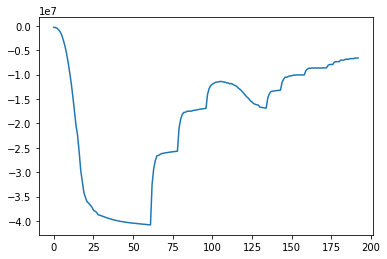

In [55]:
plt.plot(obj_total)

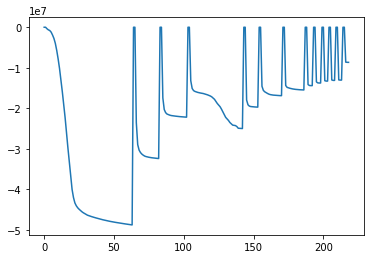

In [56]:
plt.plot(obj_relaxed_total)

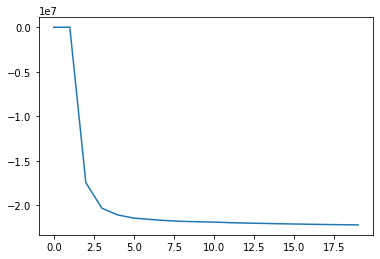

In [38]:
for i in 
plt.plot(auto_param_relaxed_obj_history[])

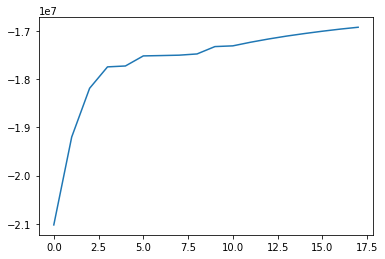

In [42]:
plt.plot(auto_param_obj_history[2])

In [12]:
data['beamlet_pos'], u_mult.shape

(array([[-70.,  15.],
        [-70.,  20.],
        [-70.,  25.],
        ...,
        [ 50.,  20.],
        [ 50.,  25.],
        [ 50.,  30.]]), (18647,))

In [13]:
data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar  1 01:37:10 2020',
 '__version__': '1.0',
 '__globals__': [],
 'Aproton': <32061x16358 sparse matrix of type '<class 'numpy.float64'>'
 	with 16735951 stored elements in Compressed Sparse Column format>,
 'Organ': array([[array(['Target'], dtype='<U6'), array(['Rectum'], dtype='<U6'),
         array(['Bladder'], dtype='<U7'), array(['R Femur'], dtype='<U7'),
         array(['L Femur'], dtype='<U7'), array(['BODY'], dtype='<U4')]],
       dtype=object),
 'beamlet_pos': array([[-70.,  15.],
        [-70.,  20.],
        [-70.,  25.],
        ...,
        [ 50.,  20.],
        [ 50.,  25.],
        [ 50.,  30.]]),
 'maxAreducedphoton': <30207x2289 sparse matrix of type '<class 'numpy.float64'>'
 	with 16478507 stored elements in Compressed Sparse Column format>,
 'num_beamlets': array([[480, 405, 497, 493, 414]], dtype=uint16),
 'num_voxels': array([[ 6782,  1773, 11595,  5958,  5952,     1]]),
 'maxAreducedproton':

In [14]:
len_mod1 = u1_guess.shape[0]
beamlet_indices = np.split(np.arange(len_mod1), np.cumsum(np.squeeze(data['num_beamlets'])))[:-1] #[:-1] because the last index is 2289
# beamlet_indices

In [15]:
u_mult[beamlet_indices[0]].shape, data['beamlet_pos'][beamlet_indices[0]].shape

((480,), (480, 2))

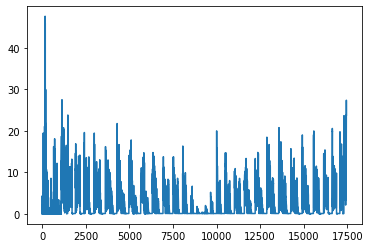

In [66]:
plt.plot(u_mult[1200:])

In [16]:
# data['beamlet_pos'][beamlet_indices[0]][:,0]

In [19]:
# data['beamlet_pos'][data['num_beamlets'][]:data['num_beamlets'][]]

In [23]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import scipy.stats as stats


# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
def plot_beam(x_beam, y_beam, u_beam):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    X = x_beam#[:, None]
    Y = y_beam#[None, :]
    Z = u_beam#[None, :]
#     X, Y, Z = np.broadcast_arrays(x, y, z)
#     print(X.shape)
#     X, Y = np.meshgrid(x_beam, y_beam)
#     Z = u_beam
    # Plot the surface.
#     surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)
    surf = ax.plot_trisurf(X, Y, Z, linewidth=0, antialiased=False, cmap=cm.coolwarm)


    # Customize the z axis.
    ax.set_zlim(*stats.describe(u_beam)[1])
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.view_init(30,60)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)


In [24]:
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# import matplotlib.pyplot as plt
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator, FormatStrFormatter
# import numpy as np


# fig = plt.figure()
# ax = fig.gca(projection='3d')

# # Make data.
# X = np.arange(-5, 5, 0.25)
# Y = np.arange(-5, 5, 0.25)
# X, Y = np.meshgrid(X, Y)
# R = np.sqrt(X**2 + Y**2)
# Z = np.sin(R)

# # Plot the surface.
# surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

# # Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# # Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

# plt.show()

In [25]:
# x = np.arange(10)[:, None, None]
# y = np.arange(10)[None, :, None]
# z = np.arange(10)[None, None, :]
# x, y, z = np.broadcast_arrays(x, y, z)

In [26]:
# z

In [27]:
# 32061x16358 sparse matrix of type '<class 'numpy.float64'>'
#  	with 16735951 stored elements in 

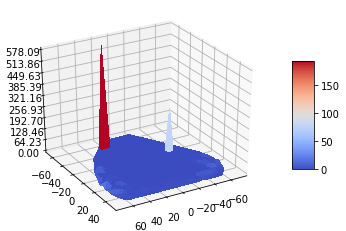

In [28]:
%matplotlib inline
x_beam = data['beamlet_pos'][beamlet_indices[0]][:,0]
y_beam = data['beamlet_pos'][beamlet_indices[0]][:,1]
u_beam = u_mult[beamlet_indices[0]]
plot_beam(x_beam, y_beam, u_beam)

In [123]:
# len(beamlet_indices)

5

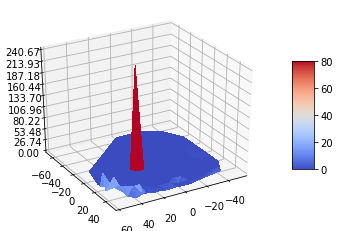

In [57]:
%matplotlib inline
x_beam = data['beamlet_pos'][beamlet_indices[1]][:,0]
y_beam = data['beamlet_pos'][beamlet_indices[1]][:,1]
u_beam = u_mult[beamlet_indices[1]]
plot_beam(x_beam, y_beam, u_beam)

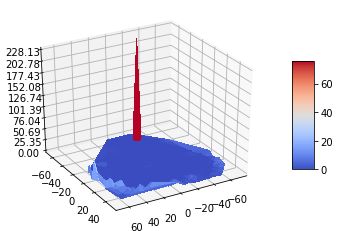

In [58]:
%matplotlib inline
x_beam = data['beamlet_pos'][beamlet_indices[2]][:,0]
y_beam = data['beamlet_pos'][beamlet_indices[2]][:,1]
u_beam = u_mult[beamlet_indices[2]]
plot_beam(x_beam, y_beam, u_beam)

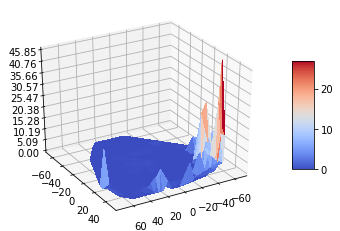

In [59]:
%matplotlib inline
x_beam = data['beamlet_pos'][beamlet_indices[3]][:,0]
y_beam = data['beamlet_pos'][beamlet_indices[3]][:,1]
u_beam = u_mult[beamlet_indices[3]]
plot_beam(x_beam, y_beam, u_beam)

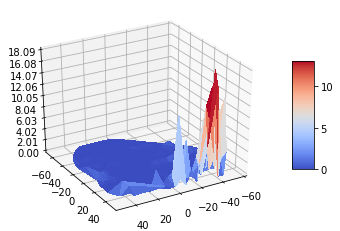

In [88]:
%matplotlib inline
x_beam = data['beamlet_pos'][beamlet_indices[4]][:,0]
y_beam = data['beamlet_pos'][beamlet_indices[4]][:,1]
u_beam = u_mult[beamlet_indices[4]]
plot_beam(x_beam, y_beam, u_beam)

In [67]:
def dif_avg(u_beam):
    u = np.sort(u_beam)[::-1]
#     print(u)
    ind = u.shape[0]//100*5
    top5 = np.mean(u[:ind])
#     bottom5 = np.mean(u[-ind:])
    mean_wo_top5 = np.mean(u[ind:])
    return top5/mean_wo_top5

In [68]:
[dif_avg(u_mult[beamlet_indices[i]]) for i in range(5)]

[148.03795020833888,
 321.0358677326187,
 53.91708757504647,
 53.228386887100264,
 74.93993040714219]

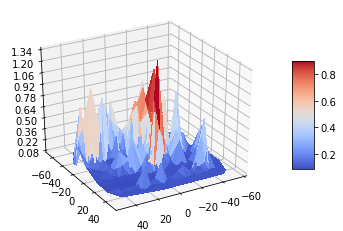

In [146]:
%matplotlib inline
x_beam = data['beamlet_pos'][beamlet_indices[4]][:,0]
y_beam = data['beamlet_pos'][beamlet_indices[4]][:,1]
u_beam = u_mult[beamlet_indices[4]]
plot_beam(x_beam, y_beam, u_beam)

In [69]:
H_con = np.concatenate([i.todense() for i in H])
np.sum(np.sum(H_con, axis = 0).T == 0)
zero_indices = np.sum(H_con, axis = 0).T == 0
zero_indices = np.array(np.squeeze(zero_indices)).reshape((-1,))
non_zero_tumor_indices = np.array(np.sum(T,axis = 0))[0] != 0
trouble_beamlets = (non_zero_tumor_indices*zero_indices).astype('bool')

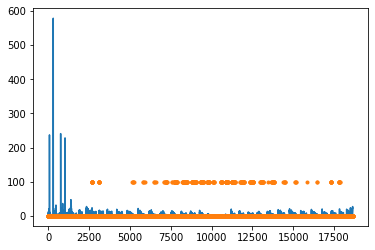

In [73]:
plt.plot(u_mult)
plt.plot(100*trouble_beamlets, '.')

Text(0.5, 1.0, 'OAR constraints')

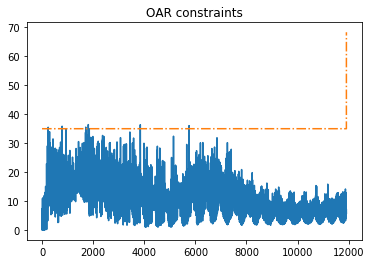

In [76]:
plt.plot(constraints_all(u_mult, H, gamma, D, C, tol = 0.05, verbose = 0)['Constr at u_opt'])
plt.plot(constraints_all(u_mult, H, gamma, D, C, tol = 0.05, verbose = 0)['actual constr'], '-.')
plt.title('OAR constraints')

In [78]:
data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar  1 01:37:10 2020',
 '__version__': '1.0',
 '__globals__': [],
 'Aproton': <32061x16358 sparse matrix of type '<class 'numpy.float64'>'
 	with 16735951 stored elements in Compressed Sparse Column format>,
 'Organ': array([[array(['Target'], dtype='<U6'), array(['Rectum'], dtype='<U6'),
         array(['Bladder'], dtype='<U7'), array(['R Femur'], dtype='<U7'),
         array(['L Femur'], dtype='<U7'), array(['BODY'], dtype='<U4')]],
       dtype=object),
 'beamlet_pos': array([[-70.,  15.],
        [-70.,  20.],
        [-70.,  25.],
        ...,
        [ 50.,  20.],
        [ 50.,  25.],
        [ 50.,  30.]]),
 'maxAreducedphoton': <30207x2289 sparse matrix of type '<class 'numpy.float64'>'
 	with 16478507 stored elements in Compressed Sparse Column format>,
 'num_beamlets': array([[480, 405, 497, 493, 414]], dtype=uint16),
 'num_voxels': array([[ 6782,  1773, 11595,  5958,  5952,     1]]),
 'maxAreducedproton':

In [77]:
len(H)

11911

In [79]:
 5958+  5952+     1

11911

In [75]:
# plt.plot(u_mult[trouble_beamlets])

In [147]:
data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar  1 01:37:10 2020',
 '__version__': '1.0',
 '__globals__': [],
 'Aproton': <32061x16358 sparse matrix of type '<class 'numpy.float64'>'
 	with 16735951 stored elements in Compressed Sparse Column format>,
 'Organ': array([[array(['Target'], dtype='<U6'), array(['Rectum'], dtype='<U6'),
         array(['Bladder'], dtype='<U7'), array(['R Femur'], dtype='<U7'),
         array(['L Femur'], dtype='<U7'), array(['BODY'], dtype='<U4')]],
       dtype=object),
 'beamlet_pos': array([[-70.,  15.],
        [-70.,  20.],
        [-70.,  25.],
        ...,
        [ 50.,  20.],
        [ 50.,  25.],
        [ 50.,  30.]]),
 'maxAreducedphoton': <30207x2289 sparse matrix of type '<class 'numpy.float64'>'
 	with 16478507 stored elements in Compressed Sparse Column format>,
 'num_beamlets': array([[480, 405, 497, 493, 414]], dtype=uint16),
 'num_voxels': array([[ 6782,  1773, 11595,  5958,  5952,     1]]),
 'maxAreducedproton':

In [125]:
stats.describe(u_beam)

DescribeResult(nobs=405, minmax=(0.08152347434216956, 1.9192951430662353), mean=0.21288197233438472, variance=0.04892313221964729, skewness=2.9727056990579275, kurtosis=12.21302764744312)

In [36]:
x = np.arange(8.0)

np.split(x, [3, 5, 6, 10])

[array([0., 1., 2.]),
 array([3., 4.]),
 array([5.]),
 array([6., 7.]),
 array([], dtype=float64)]

In [27]:
u1_guess.shape

(2289,)

In [ ]:
data[]

In [81]:
T_list, T, H, alpha, gamma, B, D, C = construct_auto_param_solver_input(np.array([45,0]), Alpha, Beta, Gamma, Delta, data, modality_names)
# u_init = 10*np.ones(2289+16358)

getting through 11912 matrices


In [82]:
%%time
u_conv, eta_0, eta, auto_param_obj_history, auto_param_relaxed_obj_history = solver_auto_param(u1_guess, T, H, alpha, gamma, B, D, C, eta_step = 0.5, ftol = 1e-3, max_iter = 300, verbose = 1)

wi update took: 2.397144317626953
      fun: 636681.3469786862
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.68707118e+00,  4.37009241e+01,  1.41468506e+00, ...,
       -2.14288099e+03, -2.68330509e+02, -2.16988028e+02])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 55
      nit: 50
   status: 1
  success: False
        x: array([0.07681422, 0.07333824, 0.07855712, ..., 0.09815469, 0.10211318,
       0.10326569])
u update took: 1.463951587677002
    iter = 1, stopping criterium:3699128.291435508, OBJ -282778.85319790954
    This iteration took: 4.231973171234131
wi update took: 1.4551668167114258
      fun: 317964.0545104684
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([  27.66696782,   34.0246152 ,   26.0846043 , ...,  576.3559134 ,
       2661.29005099, 4154.21067082])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 53
      nit: 50
   status: 1
  success: False
        

/home/rilevin/miniconda3/envs/mmort/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


wi update took: 1.4824671745300293
      fun: 2004718.9797645146
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([   6.17917316,   -8.46209575,  -11.68985905, ..., 2684.29791024,
       4390.20726742, 3487.59690765])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 52
      nit: 50
   status: 1
  success: False
        x: array([0.0770232 , 0.07343527, 0.08133198, ..., 0.08979426, 0.10457485,
       0.13738243])
u update took: 1.4567267894744873
    iter = 7, stopping criterium:0.4128526501488467, OBJ -3021168.76236459
    This iteration took: 3.3545081615448
wi update took: 1.484647512435913
      fun: 3129688.2400267557
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([  -15.17384106,   -37.40319255,   -26.46769811, ...,
       -4619.65035701, -8435.84289756, -4539.32009225])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 52
      nit: 50
   status: 1
  success: False
        x: arr

    iter = 20, stopping criterium:0.05341101474711742, OBJ -31701527.46520908
    This iteration took: 2.474825143814087
wi update took: 1.329237461090088
      fun: 42475891.35388291
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([  204.98973756,   180.31347276,   151.76498539, ...,
        -412.06532041,  -854.64502777, -1029.94572264])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 18
      nit: 16
   status: 0
  success: True
        x: array([0.        , 0.        , 0.        , ..., 0.        , 0.09439608,
       0.14692638])
u update took: 0.5131697654724121
    iter = 21, stopping criterium:0.03203383794178209, OBJ -33372562.699269682
    This iteration took: 2.219409942626953
wi update took: 1.3004400730133057
      fun: 45348187.82510865
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 185.14022829,  155.61305884,  126.54518692, ..., 1276.36251463,
        230.76716646,  291.50561804])
  

    iter = 33, stopping criterium:0.0044585697774305695, OBJ -40781340.641499765
    This iteration took: 1.891141414642334
wi update took: 1.1340603828430176
      fun: 57777325.11632722
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -31.25276654,  -20.33762069,  -14.62538081, ...,  409.72765479,
       -992.30596257, -845.11201236])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 13
      nit: 11
   status: 0
  success: True
        x: array([0.00270267, 0.00194797, 0.00135095, ..., 0.        , 0.        ,
       0.11113606])
u update took: 0.38350605964660645
    iter = 34, stopping criterium:0.004223611997678646, OBJ -40564437.47897815
    This iteration took: 1.897963523864746
wi update took: 1.1713840961456299
      fun: 57240502.908360474
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([  -38.46924557,   -23.85495709,   -16.20945912, ...,
        -170.38552157, -1098.08742336, -1367.7425044

wi update took: 1.1565017700195312
      fun: 62253274.24840963
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -50.03851335,  -43.78104391,  -44.05470317, ..., 2360.49190738,
       2151.11028928, 1653.95835946])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 6
      nit: 5
   status: 0
  success: True
        x: array([0.09055761, 0.07714415, 0.54305311, ..., 0.00783446, 0.00625968,
       0.09706465])
u update took: 0.20050740242004395
    iter = 47, stopping criterium:0.003453871434988398, OBJ -43441916.13964239
    This iteration took: 1.730591058731079
wi update took: 1.0993146896362305
      fun: 61668392.29649271
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -41.82623556,  -36.92448872,  -39.14214898, ..., 2736.95960964,
       2569.17919076, 1619.49266096])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 6
      nit: 5
   status: 0
  success: True
        x: a

wi update took: 1.2300357818603516
      fun: 47316440.76503793
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -26.84307653,  -23.6867917 ,  -20.10389328, ..., -499.01418788,
        161.14804152, -223.0563877 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 16
      nit: 14
   status: 0
  success: True
        x: array([2.67852278e-01, 2.59691358e-01, 3.97612619e+00, ...,
       2.16914580e-02, 3.86732429e-03, 5.28505218e-02])
u update took: 0.453538179397583
    iter = 3, stopping criterium:0.04411351818125162, OBJ -29988753.370297857
    This iteration took: 2.103933095932007
wi update took: 1.2239906787872314
      fun: 43816442.33771526
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -31.73731739,  -28.03095213,  -23.88089892, ..., -470.54543026,
       -914.20000816, -425.31508774])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 12
      nit: 10
   status: 0
  s

    iter = 4, stopping criterium:0.02309957194584748, OBJ -18186028.216211587
    This iteration took: 1.962528944015503
wi update took: 0.9090869426727295
      fun: 26564835.550014302
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([  12.01117263,    8.5197503 ,    9.75053305, ..., -401.70578415,
       -808.32724467,  146.48617468])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 18
      nit: 17
   status: 0
  success: True
        x: array([2.18325022e+00, 1.71719266e+00, 5.29668540e+00, ...,
       3.24257403e-02, 5.35786298e-04, 7.24137068e-03])
u update took: 0.5205845832824707
    iter = 5, stopping criterium:0.010666899452183477, OBJ -17664009.938488223
    This iteration took: 1.8030812740325928
wi update took: 0.9430418014526367
      fun: 25465647.51201521
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 11.3167987 ,   5.94241187,   9.23397252, ..., 733.64767152,
       946.34690416, 44

    iter = 5, stopping criterium:1.5457453356717338e-05, OBJ -11368436.069250157
    This iteration took: 1.254871129989624
Iter  4 # of violated constr: -50
wi update took: 1.0030889511108398
      fun: 19376727.079520475
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([  144.71611359,   122.93386442,   108.64185276, ...,
       -1809.66064333,  2307.71679961,  5662.01547754])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 51
      nit: 50
   status: 1
  success: False
        x: array([4.55948798, 3.21840707, 6.45039706, ..., 0.04790849, 0.        ,
       0.        ])
u update took: 1.5200395584106445
    iter = 1, stopping criterium:68805149.67959684, OBJ -9122079.779891364
    This iteration took: 2.927607297897339
wi update took: 0.7715582847595215
      fun: 13840121.706894988
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([   37.04633831,    34.34125496,    23.47947611, ...,
       -2878.621907

    iter = 6, stopping criterium:0.026132469975878436, OBJ -4963026.43529516
    This iteration took: 2.722527027130127
wi update took: 0.9139800071716309
      fun: 6021012.213098018
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 114.5304904 ,   90.57611037,   29.90233107, ...,  395.00521765,
       1016.89365353, 2929.21962096])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 52
      nit: 50
   status: 1
  success: False
        x: array([4.71041037, 3.09249397, 6.44140496, ..., 0.01702547, 0.02987031,
       0.        ])
u update took: 1.299795150756836
    iter = 7, stopping criterium:0.02554429112428531, OBJ -4994831.823379131
    This iteration took: 2.5765926837921143
wi update took: 0.9273941516876221
      fun: 5999709.609022572
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 138.63530744,  104.56710759,   43.36608954, ...,  785.103531  ,
       1493.13591938, 2843.51688728])
  message: b'

wi update took: 0.9503753185272217
      fun: 10327976.189365912
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([  811.60808632,   509.70978054,   156.37717062, ...,
         351.97851887, -1139.84731061,  -266.1685216 ])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 80
      nit: 77
   status: 1
  success: False
        x: array([0.00000000e+00, 0.00000000e+00, 4.29116297e+00, ...,
       0.00000000e+00, 1.30920807e-01, 8.22694460e-04])
u update took: 2.2479352951049805
    iter = 20, stopping criterium:0.019947775951598228, OBJ -8891090.057270339
    This iteration took: 3.601783275604248
wi update took: 0.9522926807403564
      fun: 10959728.193661451
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 861.33507569,  534.53153312,  146.63213732, ...,  809.03502667,
       -511.60114658,  295.2315623 ])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 85
      nit: 82
   status: 1


wi update took: 0.9431407451629639
      fun: 7930853.032556579
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 617.60003965,  222.73948993,  -35.75937398, ..., 1649.21073348,
       1257.09193419, 1883.88652508])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 51
      nit: 50
   status: 1
  success: False
        x: array([0.        , 0.        , 2.3223484 , ..., 0.0324386 , 0.04444804,
       0.        ])
u update took: 1.2365872859954834
    iter = 5, stopping criterium:0.04626153209722758, OBJ -6854945.131656717
    This iteration took: 2.5776360034942627
wi update took: 0.9531781673431396
      fun: 7922405.698672778
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 623.8711455 ,  237.02873225,  -12.07895459, ...,  131.4512269 ,
        186.83903249, 1233.62048426])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 51
      nit: 50
   status: 1
  success: False
        x: array

    iter = 18, stopping criterium:0.01518967952368453, OBJ -9906696.221012086
    This iteration took: 3.345726251602173
wi update took: 0.9744923114776611
      fun: 11939281.854483243
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 418.17646106,  149.19833268,  -29.30190352, ...,   15.29934488,
        570.52687586, -333.22990086])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 75
      nit: 73
   status: 1
  success: False
        x: array([0.        , 0.        , 2.55548091, ..., 0.05805651, 0.        ,
       0.0039782 ])
u update took: 2.020096778869629
    iter = 19, stopping criterium:0.01436078212826419, OBJ -10058238.272848057
    This iteration took: 3.4382150173187256
wi update took: 0.9939038753509521
      fun: 12121063.796714285
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 449.39523113,  167.82284206,  -30.04960897, ..., -658.87301836,
        735.03530718,  236.3375442 ])
  messag

    iter = 31, stopping criterium:0.006501336577817274, OBJ -12986302.13541143
    This iteration took: 1.8755640983581543
wi update took: 1.035799264907837
      fun: 16419241.67390787
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([587.49684275, 232.37905603,  -6.27776415, ..., 433.43832798,
       365.83699806, 158.74457662])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 13
      nit: 11
   status: 0
  success: True
        x: array([0.        , 0.        , 2.9633891 , ..., 0.01533842, 0.        ,
       0.        ])
u update took: 0.37629151344299316
    iter = 32, stopping criterium:0.0068020861647873476, OBJ -13228841.228572797
    This iteration took: 1.8371334075927734
wi update took: 1.0167670249938965
      fun: 16833289.870245542
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([610.91051558, 244.24266955,  -3.98123939, ..., 612.30505463,
       617.90008108, 310.07823232])
  message: b'

wi update took: 1.03782320022583
      fun: 21458172.943749912
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 944.828775  ,  375.21765905,   25.7608267 , ..., 1843.22010679,
        365.63141253, -144.66039821])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 13
      nit: 11
   status: 0
  success: True
        x: array([0.00000000e+00, 0.00000000e+00, 2.23901813e+00, ...,
       0.00000000e+00, 0.00000000e+00, 9.06786188e-05])
u update took: 0.3807084560394287
    iter = 45, stopping criterium:0.014377911645686133, OBJ -16345129.380683074
    This iteration took: 1.8349628448486328
wi update took: 1.013627290725708
      fun: 21907360.214559097
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 993.62455753,  394.11170767,   26.16065666, ..., 1531.92704057,
         42.84504185, -393.36732594])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 13
      nit: 11
   status: 0


wi update took: 1.0130858421325684
      fun: 28874899.623606674
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([1103.7206386 ,  315.19533029,   -7.56819109, ..., 2531.93862302,
        810.96805685,  271.86317321])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 14
      nit: 13
   status: 0
  success: True
        x: array([0.        , 0.        , 2.41226168, ..., 0.        , 0.        ,
       0.00656612])
u update took: 0.33651185035705566
    iter = 58, stopping criterium:0.0028741889507946494, OBJ -22234800.085324157
    This iteration took: 1.6718075275421143
wi update took: 0.947913408279419
      fun: 29057054.750701465
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([1125.9741301 ,  323.71785037,   -3.62386637, ..., 1811.20523878,
       -163.38326102, -527.91782955])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 12
      nit: 11
   status: 0
  success: True
    

    iter = 7, stopping criterium:0.0021322494880049504, OBJ -16856609.273645908
    This iteration took: 1.461796760559082
wi update took: 0.7923111915588379
      fun: 22454757.07006814
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([1205.34187743,  204.10496316,  -53.65936688, ..., 2092.83818288,
        312.29123129, -173.63689334])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 12
      nit: 9
   status: 0
  success: True
        x: array([0.        , 0.        , 2.47067575, ..., 0.        , 0.        ,
       0.02902242])
u update took: 0.2860138416290283
    iter = 8, stopping criterium:0.0016648306249906041, OBJ -16851276.177826077
    This iteration took: 1.4016766548156738
wi update took: 0.7941312789916992
      fun: 22423208.462049186
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([1210.83017818,  205.83639052,  -55.26945341, ..., 1457.93416997,
        -40.32154979, -311.04712912])
  m

    iter = 7, stopping criterium:0.0052118899608364746, OBJ -12607919.930994555
    This iteration took: 1.4386022090911865
wi update took: 0.7915115356445312
      fun: 16622480.291172694
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([1152.09705552,   62.55663175,  -45.30736084, ..., 2445.77637019,
        477.32197376,  295.12015455])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 12
      nit: 9
   status: 0
  success: True
        x: array([0.        , 0.        , 3.09806416, ..., 0.        , 0.        ,
       0.        ])
u update took: 0.305966854095459
    iter = 8, stopping criterium:0.0010617021471738253, OBJ -12602116.198519286
    This iteration took: 1.4237661361694336
wi update took: 0.7825057506561279
      fun: 16574128.648901338
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.98511367e+02,  9.73641971e-01, -4.24146308e+01, ...,
        3.97697272e+03,  2.77548807e+03,  2.43770

    iter = 2, stopping criterium:0.12270352023170762, OBJ -8499313.722389108
    This iteration took: 2.1532230377197266
wi update took: 0.7251527309417725
      fun: 11289611.413209248
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 846.50745158, -115.5078621 ,  -38.66541191, ..., 5910.07662898,
       6616.11485218, 6529.20914909])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 52
      nit: 50
   status: 1
  success: False
        x: array([0.        , 1.19815733, 3.86013015, ..., 0.        , 0.        ,
       0.        ])
u update took: 1.4474825859069824
    iter = 3, stopping criterium:0.04588203936357671, OBJ -8321007.536141002
    This iteration took: 2.5466527938842773
wi update took: 0.9756760597229004
      fun: 10782630.992546683
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 796.25726327,  -90.39302361,  -33.92881083, ..., 4350.00084079,
       4229.06311443, 4552.73440418])
  message

wi update took: 0.8961982727050781
      fun: 9887234.532040132
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 611.65103029,  -11.40598534,   -5.60846922, ..., 2019.49316393,
        637.0143843 ,   97.65514449])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 3
      nit: 1
   status: 0
  success: True
        x: array([0.00000000e+00, 1.67077307e+00, 4.04301974e+00, ...,
       0.00000000e+00, 0.00000000e+00, 8.45015671e-06])
u update took: 0.11515951156616211
    iter = 16, stopping criterium:0.0035419891349921474, OBJ -8153323.597749435
    This iteration took: 1.4567253589630127
wi update took: 0.869600772857666
      fun: 9887734.680608666
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 611.72042704,  -11.42096399,   -5.61591336, ..., 2019.55453052,
        637.05291948,   97.67587706])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 3
      nit: 1
   status: 0
  s

wi update took: 0.9686446189880371
      fun: 8658325.467199082
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -72.85012308,  -28.79637791,  -13.03397523, ...,  -55.9831533 ,
       -667.71045566,    4.09505096])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 53
      nit: 51
   status: 1
  success: False
        x: array([5.39420200e-01, 2.27403863e+00, 4.26671917e+00, ...,
       0.00000000e+00, 9.21419088e-05, 0.00000000e+00])
u update took: 1.4184420108795166
    iter = 12, stopping criterium:0.00785203548867186, OBJ -7390700.343275767
    This iteration took: 2.794945240020752
wi update took: 0.914797306060791
      fun: 8611834.118570823
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -75.38522762,  -32.41620466,  -10.28342418, ...,  603.46227924,
       -336.23529638,  147.97550215])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 55
      nit: 53
   status: 1
  success:

      fun: 8519155.6179755
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.73333878e-01, -1.07529397e+01, -3.32812998e+00, ...,
        1.78780076e+02,  8.08985429e+02,  1.48575169e+03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 34
      nit: 32
   status: 0
  success: True
        x: array([1.4954588 , 2.69890537, 4.44301731, ..., 0.        , 0.        ,
       0.        ])
u update took: 1.0062096118927002
    iter = 25, stopping criterium:0.001981311735111709, OBJ -7601882.9907180965
    This iteration took: 2.290027618408203
wi update took: 0.9300975799560547
      fun: 8541272.344320996
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -6.10192357, -20.06563692,  -8.75355772, ..., 367.21041767,
       715.9452827 , 657.64124354])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 7
      nit: 5
   status: 0
  success: True
        x: array([1.49529662, 2.70001765,

Iter  16 # of violated constr: -10
wi update took: 1.0286824703216553
      fun: 7319416.067252474
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([-164.24378218,   15.60480881,   36.38926719, ..., -465.12090537,
       5692.64774676, 5559.04593985])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 52
      nit: 50
   status: 1
  success: False
        x: array([3.3041298 , 3.66426319, 4.84232018, ..., 0.        , 0.        ,
       0.        ])
u update took: 1.5091485977172852
    iter = 1, stopping criterium:114066575.30453743, OBJ -6249674.90325279
    This iteration took: 2.922403573989868
wi update took: 0.9314882755279541
      fun: 6797298.033116574
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([-130.87787373,   -6.78828348,   17.20622637, ..., 1642.1603453 ,
       3851.04666929, 1515.75842576])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 52
      nit: 50
   status: 1
 

    iter = 1, stopping criterium:113573295.67327473, OBJ -5827948.532374356
    This iteration took: 2.6031343936920166
wi update took: 0.7440133094787598
      fun: 6044039.70962382
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -16.52221993,   -6.22726487,   -1.91454448, ...,  499.57705555,
       1330.40180252,  495.70670198])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 3
      nit: 1
   status: 0
  success: True
        x: array([3.85170059e+00, 3.90197519e+00, 4.93640307e+00, ...,
       2.59665900e-03, 0.00000000e+00, 0.00000000e+00])
u update took: 0.10965085029602051
    iter = 2, stopping criterium:0.0023429797470311126, OBJ -5828212.678356914
    This iteration took: 1.207158088684082
wi update took: 0.7230637073516846
      fun: 6044471.609745525
 hess_inv: <2289x2289 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -16.56698677,   -6.19396232,   -1.83670116, ...,  516.61601009,
       1350.1114882 ,  5

CPU times: user 24.8 ms, sys: 31.9 ms, total: 56.7 ms
Wall time: 53.2 ms


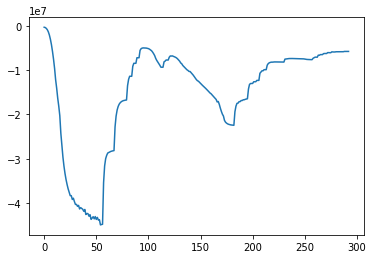

In [84]:
%%time
import matplotlib.pyplot as plt
plt.plot(np.concatenate(auto_param_obj_history))

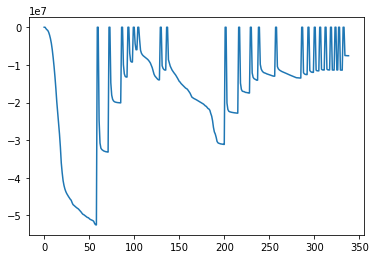

In [85]:
plt.plot(np.concatenate(auto_param_relaxed_obj_history))

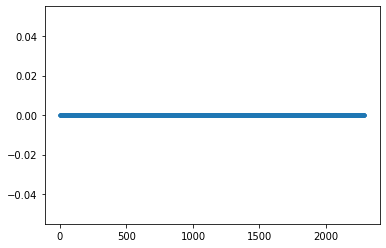

In [108]:
# plt.plot(u_conv)
plt.plot(trouble_beamlets[:2289], '.')

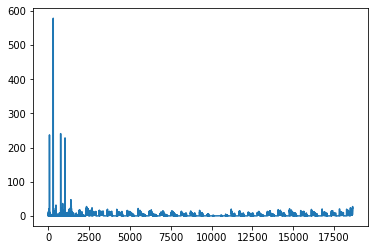

In [114]:
plt.plot(u_mult)
# plt.plot(, '.')

In [105]:
u_conv.shape

(2289,)

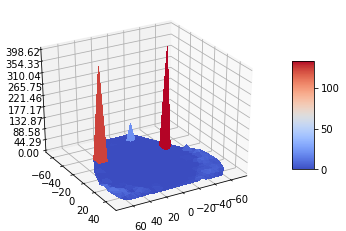

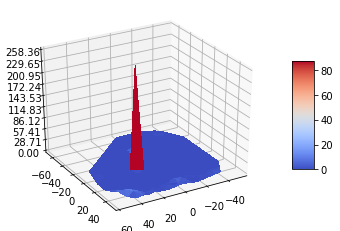

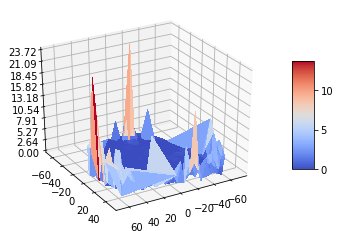

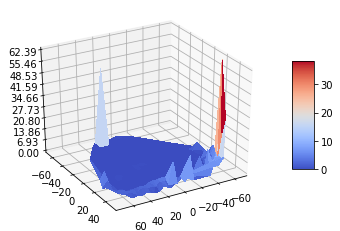

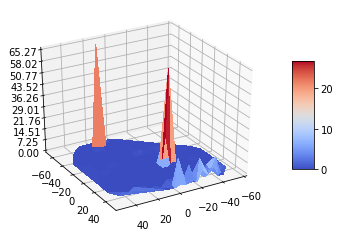

In [93]:
%matplotlib inline
for i in range(5):
    x_beam = data['beamlet_pos'][beamlet_indices[i]][:,0]
    y_beam = data['beamlet_pos'][beamlet_indices[i]][:,1]
    u_beam = u_conv[beamlet_indices[i]]
    plot_beam(x_beam, y_beam, u_beam)

In [26]:
plt.plot(constraints_all(u_conv, H, gamma, D, C, tol = 0.05, verbose = 0)['Constr at u_opt'])
plt.plot(constraints_all(u_conv, H, gamma, D, C, tol = 0.05, verbose = 0)['actual constr'], '-.')
plt.title('OAR constraints')

NameError: name 'plt' is not defined

In [119]:
data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar  1 01:37:10 2020',
 '__version__': '1.0',
 '__globals__': [],
 'Aproton': <32061x16358 sparse matrix of type '<class 'numpy.float64'>'
 	with 16735951 stored elements in Compressed Sparse Column format>,
 'Organ': array([[array(['Target'], dtype='<U6'), array(['Rectum'], dtype='<U6'),
         array(['Bladder'], dtype='<U7'), array(['R Femur'], dtype='<U7'),
         array(['L Femur'], dtype='<U7'), array(['BODY'], dtype='<U4')]],
       dtype=object),
 'beamlet_pos': array([[-70.,  15.],
        [-70.,  20.],
        [-70.,  25.],
        ...,
        [ 50.,  20.],
        [ 50.,  25.],
        [ 50.,  30.]]),
 'maxAreducedphoton': <30207x2289 sparse matrix of type '<class 'numpy.float64'>'
 	with 16478507 stored elements in Compressed Sparse Column format>,
 'num_beamlets': array([[480, 405, 497, 493, 414]], dtype=uint16),
 'num_voxels': array([[ 6782,  1773, 11595,  5958,  5952,     1]]),
 'maxAreducedproton':

### Investigate the infinity beamlets (they don't exist with Body)

In [115]:
# H_con = np.concatenate([i.todense() for i in H])
# np.sum(np.sum(H_con, axis = 0).T == 0)
# zero_indices = np.sum(H_con, axis = 0).T == 0
# zero_indices = np.array(np.squeeze(zero_indices)).reshape((-1,))
# non_zero_tumor_indices = np.array(np.sum(T,axis = 0))[0] != 0
# trouble_beamlets = (non_zero_tumor_indices*zero_indices).astype('bool')

In [161]:
Aphoton = np.array(data['Aphoton'].todense())

In [126]:
np.sum([ 6782,  1773, 11595,  5958,  5952,     1])

32061

In [162]:
photon_nonzero_tumor_indices = np.sum(Aphoton[:6782], axis = 0) != 0#.shape
photon_zero_OAR_indices = np.sum(Aphoton[6782:], axis = 0) == 0

In [175]:
photon_zero_OAR_indices = np.sum(Aphoton[-(5958+5952):-1], axis = 0) == 0

In [167]:
np.sum(photon_zero_OAR_indices)

0

In [172]:
proton_zero_OAR_indices = np.sum(Aproton[-(5958+5952):-1], axis = 0) == 0

In [173]:
np.sum(proton_zero_OAR_indices)

8654

In [170]:
Aproton = np.array(data['Aproton'].todense())

In [171]:
Aproton.shape

(32061, 16358)

In [142]:
nonzero_tumor_indices = np.sum(Aproton[:6782], axis = 0) != 0#.shape
zero_OAR_indices = np.sum(Aproton[6782:], axis = 0) == 0

In [145]:
zero_OAR_indices.shape

(16358,)

In [146]:
u_mult[2289:].shape

(16358,)

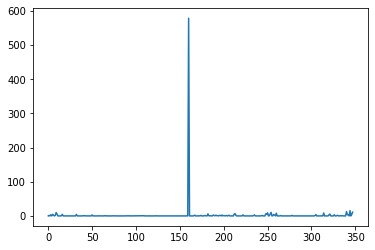

In [178]:
plt.plot(u_mult[:2289][photon_zero_OAR_indices])

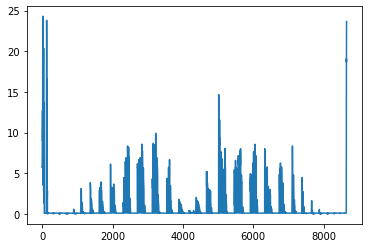

In [181]:
plt.plot(u_mult[2289:][proton_zero_OAR_indices])

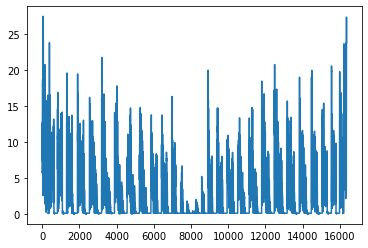

In [179]:
plt.plot(u_mult[2289:])

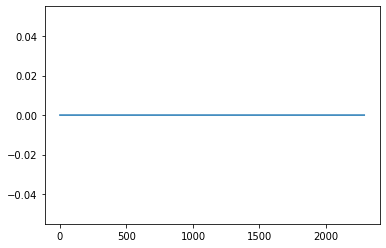

In [116]:
plt.plot(trouble_beamlets)